# 119-1 e 119-2 - Sentence Transformers - RoBERTa Large All

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\msanto22\AppData\Local\Temp\ipykernel_26392\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Sentence Transformers

### RoBERTa Large All

In [29]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
import numpy as np

In [30]:
# Carregar modelo e tokenizer do Sentence Transformers

model_name = 'sentence-transformers/all-roberta-large-v1'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [31]:
# Função para pooling médio
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # Primeiro elemento contém os embeddings dos tokens
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Funções para gerar os vetores de embeddings
def gerar_embedding(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        model_output = model(**inputs)
        # Aplicar pooling médio e normalizar
        sentence_embedding = mean_pooling(model_output, inputs['attention_mask'])
        return sentence_embedding[0].numpy()

def gerar_embeddings_com_hierarquia(json_data, path=''):
    embeddings_hierarquicos = {}
    for chave, valor in json_data.items():
        novo_caminho = f"{path}/{chave}" if path else chave
        if isinstance(valor, dict):
            embeddings_hierarquicos.update(gerar_embeddings_com_hierarquia(valor, novo_caminho))
        elif isinstance(valor, list):
            for texto in valor:
                embedding = gerar_embedding(texto)
                embeddings_hierarquicos[novo_caminho] = embedding
        elif isinstance(valor, str):
            embedding = gerar_embedding(valor)
            embeddings_hierarquicos[novo_caminho] = embedding
    return embeddings_hierarquicos


In [32]:
# Carregar e combinar múltiplos JSONs
def carregar_e_combinar_jsons(*nomes_arquivos, diretorio='idx-07-dimep-JSON'):
    dados_combinados = {}
    for nome_arquivo in nomes_arquivos:
        caminho_completo = f"{diretorio}/{nome_arquivo}.json"
        with open(caminho_completo, 'r', encoding='utf-8') as file:
            dados = json.load(file)
            dados_combinados.update(dados)
    return dados_combinados

# Carregar e combinar os dados dos arquivos JSON
json_data = carregar_e_combinar_jsons('119-1', '119-2')


In [ ]:
# Gerar embeddings
embeddings_hierarquicos = gerar_embeddings_com_hierarquia(json_data)

# Salvar os embeddings
np.save('embeddings_sentence_transformers_119-1_119-2.npy', embeddings_hierarquicos)


## Validação dos Embeddings

In [33]:
# Carregar os embeddings
embeddings = np.load('embeddings_sentence_transformers_119-1_119-2.npy', allow_pickle=True)

# Verificar o tipo do objeto carregado
print("Tipo do objeto carregado:", type(embeddings))

# Se for um dicionário ou uma lista, tentar imprimir uma parte dele
if isinstance(embeddings, dict):
    print("Alguns embeddings (chave e vetor):")
    for key in list(embeddings.keys())[:1000]:
        print(key, embeddings[key])
elif isinstance(embeddings, list):
    print("Todos os elementos da lista:", embeddings[:1000])
else:
    print("Conteúdo do objeto:", embeddings)


Tipo do objeto carregado: <class 'numpy.ndarray'>
Conteúdo do objeto: {'Travelers Cheques American Express - TC AMEX/Venda': array([ 0.6488278 ,  0.40970433, -0.55522853, ..., -1.0801727 ,
        0.50728506,  0.5149596 ], dtype=float32), 'Travelers Cheques American Express - TC AMEX/Compra': array([ 0.6115734 ,  0.7256374 , -0.96863735, ..., -1.2152556 ,
        0.33693388,  0.13727258], dtype=float32), 'Travelers Cheques American Express - TC AMEX/Reembolso': array([ 1.6060642 ,  0.01346059, -0.3936774 , ..., -0.76458347,
        0.12584482, -0.03783796], dtype=float32), 'Travelers Cheques Banco do Brasil - TCBB/Vendas': array([ 0.73758566, -0.40913963, -0.18235117, ..., -1.847018  ,
        0.6864571 ,  0.07479933], dtype=float32), 'Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature': array([ 0.08617873, -0.11855439, -0.6071603 , ..., -1.2870212 ,
       -0.29333046, -1.1452302 ], dtype=float32), 'Travelers Cheques Banco do Brasil - TCBB/Características do TCBB': array([ 0

In [34]:
# Verificar alguns embeddings
for key in list(embeddings.item().keys())[:1000]:
    embedding = embeddings.item()[key]
    print(f"Embedding para '{key}': Shape - {embedding.shape}, Tipo - {embedding.dtype}")
    print(embedding, "\n")


Embedding para 'Travelers Cheques American Express - TC AMEX/Venda': Shape - (1024,), Tipo - float32
[ 0.6488278   0.40970433 -0.55522853 ... -1.0801727   0.50728506
  0.5149596 ] 

Embedding para 'Travelers Cheques American Express - TC AMEX/Compra': Shape - (1024,), Tipo - float32
[ 0.6115734   0.7256374  -0.96863735 ... -1.2152556   0.33693388
  0.13727258] 

Embedding para 'Travelers Cheques American Express - TC AMEX/Reembolso': Shape - (1024,), Tipo - float32
[ 1.6060642   0.01346059 -0.3936774  ... -0.76458347  0.12584482
 -0.03783796] 

Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Vendas': Shape - (1024,), Tipo - float32
[ 0.73758566 -0.40913963 -0.18235117 ... -1.847018    0.6864571
  0.07479933] 

Embedding para 'Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature': Shape - (1024,), Tipo - float32
[ 0.08617873 -0.11855439 -0.6071603  ... -1.2870212  -0.29333046
 -1.1452302 ] 

Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Características do TCB

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Verificar a forma de alguns embeddings
for key in list(embeddings.item().keys())[:1000]:
    embedding = embeddings.item()[key]
    print(f"Embedding para '{key}': Shape - {embedding.shape}")


Embedding para 'Travelers Cheques American Express - TC AMEX/Venda': Shape - (1024,)
Embedding para 'Travelers Cheques American Express - TC AMEX/Compra': Shape - (1024,)
Embedding para 'Travelers Cheques American Express - TC AMEX/Reembolso': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Vendas': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Características do TCBB': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Reembolso': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular': Shape - (1024,)
Embedding para 'Amex - Conferência de Estoque/Agências e PSO/SOP': Shape - (1024,)
Embedding para 'Amex - Extravio/Agências': Shape - (1024,)
Embedding para 'Amex - Destruição/Agências': Shape - (1024,)
Embedding para 'Amex - Free Exchange/Agên

In [35]:
# Achatar os embeddings para 1D se eles forem 2D
flattened_embeddings = [embeddings.item()[key].flatten() for key in embeddings.item().keys()]

# Convertendo de volta para array NumPy
flattened_embeddings = np.array(flattened_embeddings)

# Obter o número total de embeddings
n_samples = len(flattened_embeddings)

# Ajustar a perplexidade para um valor adequado
perplexity = max(5, min(n_samples - 1, 1000))  # Definindo um limite mínimo de 5

In [36]:
# Verificação Simples dos Embeddings

for embedding in flattened_embeddings[:1000]:
    print("Média:", np.mean(embedding))
    print("Desvio padrão:", np.std(embedding), "\n")


Média: 0.0076724645
Desvio padrão: 0.660162 

Média: 0.004979383
Desvio padrão: 0.7262754 

Média: 0.0023360085
Desvio padrão: 0.76466596 

Média: 0.004018102
Desvio padrão: 0.735384 

Média: 0.007765308
Desvio padrão: 0.69771034 

Média: 0.0020618048
Desvio padrão: 0.7754426 

Média: 0.0053002797
Desvio padrão: 0.686054 

Média: 0.0067546647
Desvio padrão: 0.6795565 

Média: 0.007479054
Desvio padrão: 0.6674875 

Média: 0.007961743
Desvio padrão: 0.6532468 

Média: 0.009166535
Desvio padrão: 0.6435598 

Média: 0.008967708
Desvio padrão: 0.63568276 

Média: 0.005799843
Desvio padrão: 0.7401304 

Média: 0.0060300194
Desvio padrão: 0.7279009 

Média: 0.007615107
Desvio padrão: 0.6695496 

Média: 0.009102162
Desvio padrão: 0.63769275 

Média: 0.004006927
Desvio padrão: 0.7459991 



Text(0, 0.5, 'Componente 2')

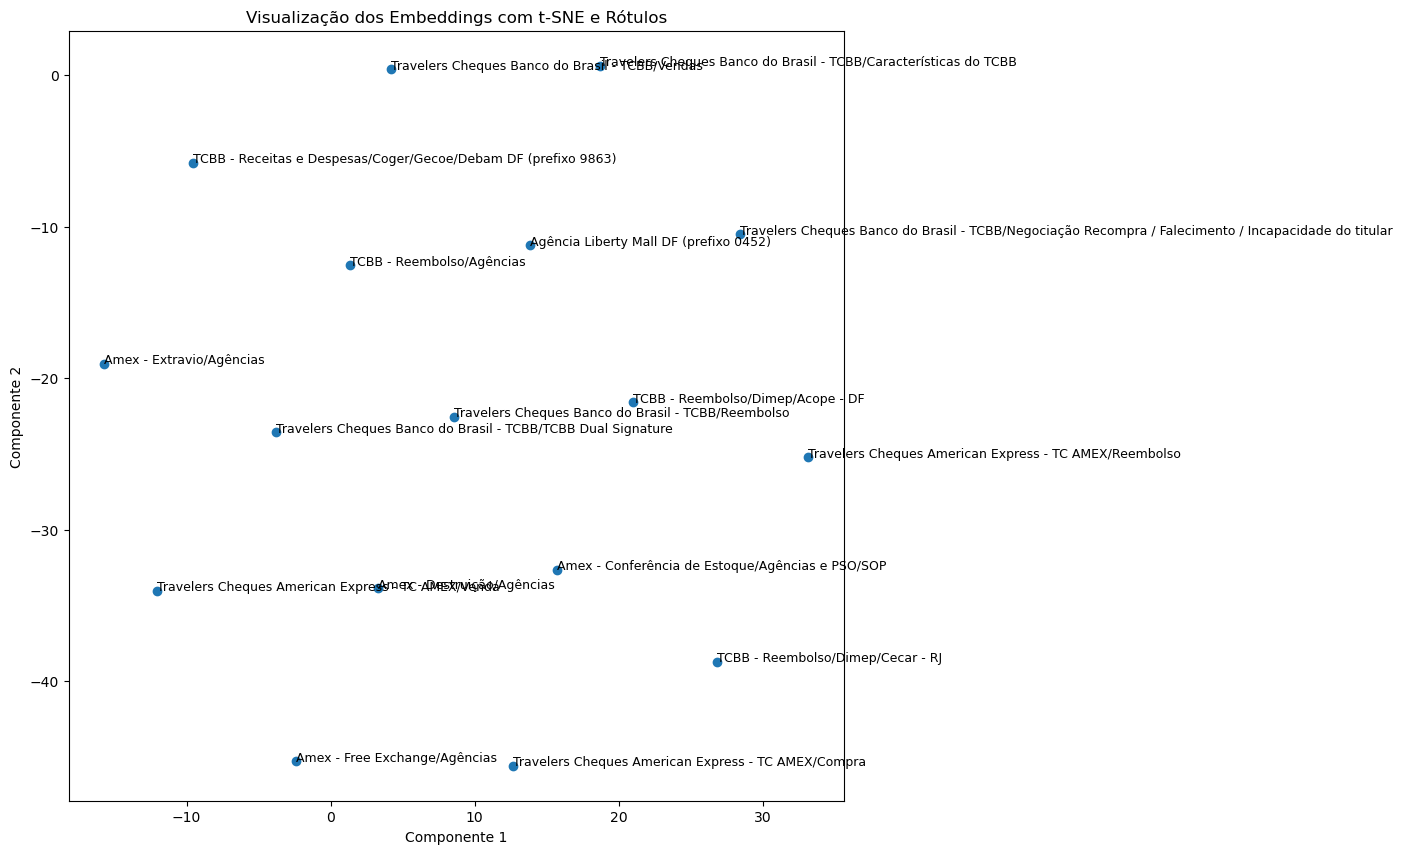

In [37]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE
embeddings_2d = TSNE(n_components=2, perplexity=perplexity).fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 2D dos embeddings com rótulos
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Adicionar rótulos aos pontos
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualização dos Embeddings com t-SNE e Rótulos")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")


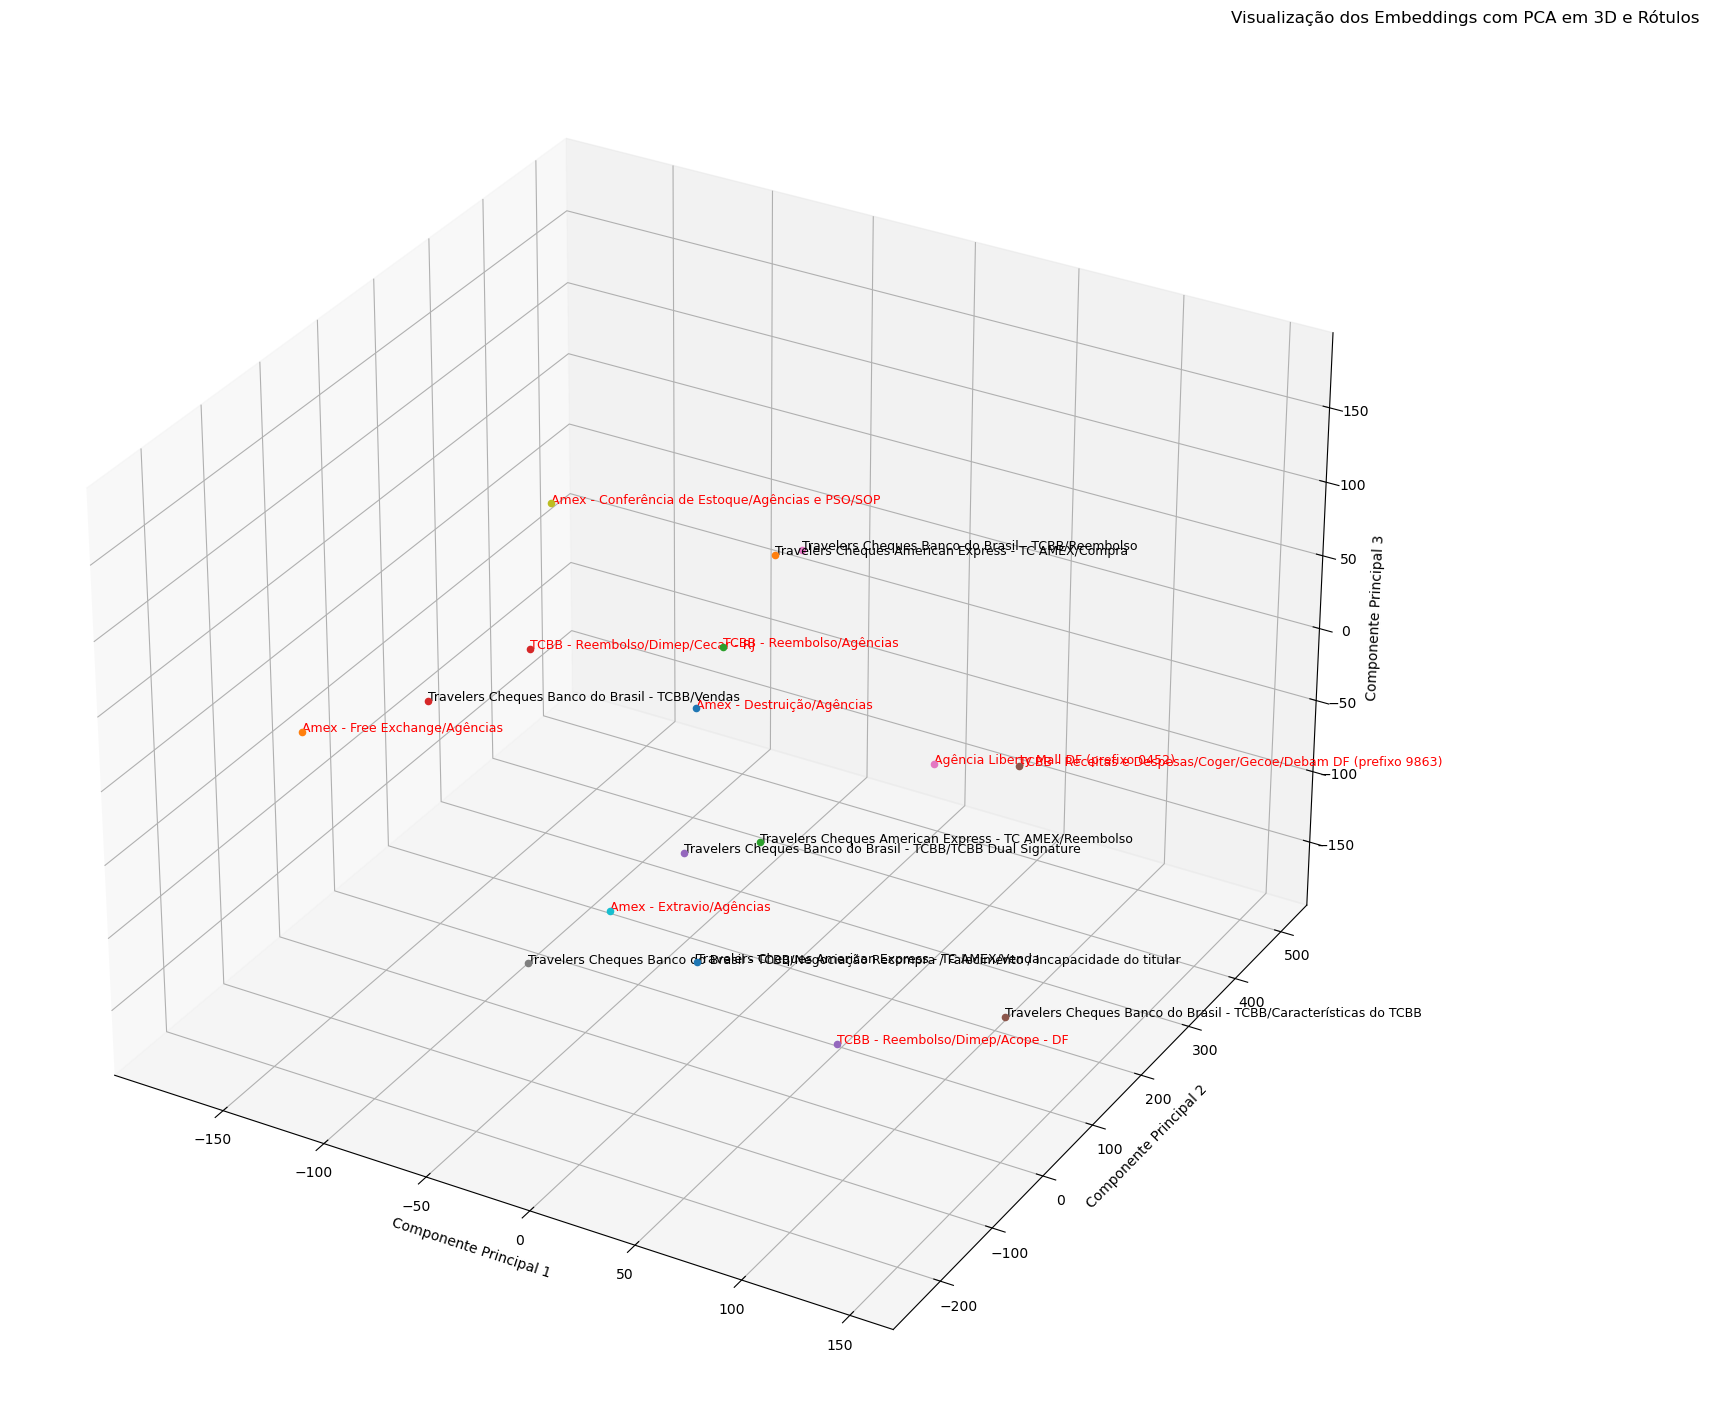

In [38]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE
embeddings_3d = TSNE(n_components=3, perplexity=perplexity).fit_transform(flattened_embeddings)

fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]


# Iterar sobre os embeddings
for i in range(embeddings_3d.shape[0]):
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2])
    
    # Verificar se o rótulo está entre os últimos 9
    if i <= 7:
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], labels[i], fontsize=9)        
    else:
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], labels[i], color='red', fontsize=9)

        
ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.title.set_position([1.05, 0.2])


# Ajustar a posição do título para evitar o corte
ax.title.set_position([1.05, 0.2])  # Ajuste conforme necessário

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

# Supondo que `embeddings_3d` seja a sua matriz de embeddings após aplicar t-SNE e contenha 8 vetores
# Calcular a similaridade de cosseno entre esses 9 embeddings
similarity_matrix = cosine_similarity(embeddings_3d)

# Imprimir a matriz de similaridade
print("Matriz de Similaridade de Cosseno:")
print(similarity_matrix)


Matriz de Similaridade de Cosseno:
[[ 1.         -0.4852762   0.8974987  -0.58844435 -0.2708206   0.45444867
   0.5816908   0.6111507  -0.862946   -0.54507464 -0.9369072   0.16544086
   0.43435246  0.03711222 -0.08330142  0.20316988 -0.57839644]
 [-0.4852762   1.         -0.15775669 -0.15100561 -0.6701485  -0.32519436
   0.41533637 -0.9479841   0.66876847 -0.45915768  0.18014704 -0.36321363
   0.55735165  0.40862367 -0.6389223   0.5455417   0.47929764]
 [ 0.8974987  -0.15775669  0.99999994 -0.881281   -0.4444858   0.6398444
   0.72712153  0.23005538 -0.81109536 -0.71124125 -0.89358765 -0.23928961
   0.60808414 -0.07843915 -0.13072145  0.6136797  -0.20728424]
 [-0.58844435 -0.15100561 -0.881281    1.0000001   0.43035087 -0.7690051
  -0.63999355  0.18234931  0.6299858   0.64895153  0.6103032   0.65668136
  -0.56773275  0.2891462   0.04010976 -0.89756215 -0.27132788]
 [-0.2708206  -0.6701485  -0.4444858   0.43035087  1.          0.2458543
  -0.9354528   0.43898293 -0.15075356  0.945636   

Text(0.5, 1.0, 'Heatmap da Similaridade de Cosseno t-SNE')

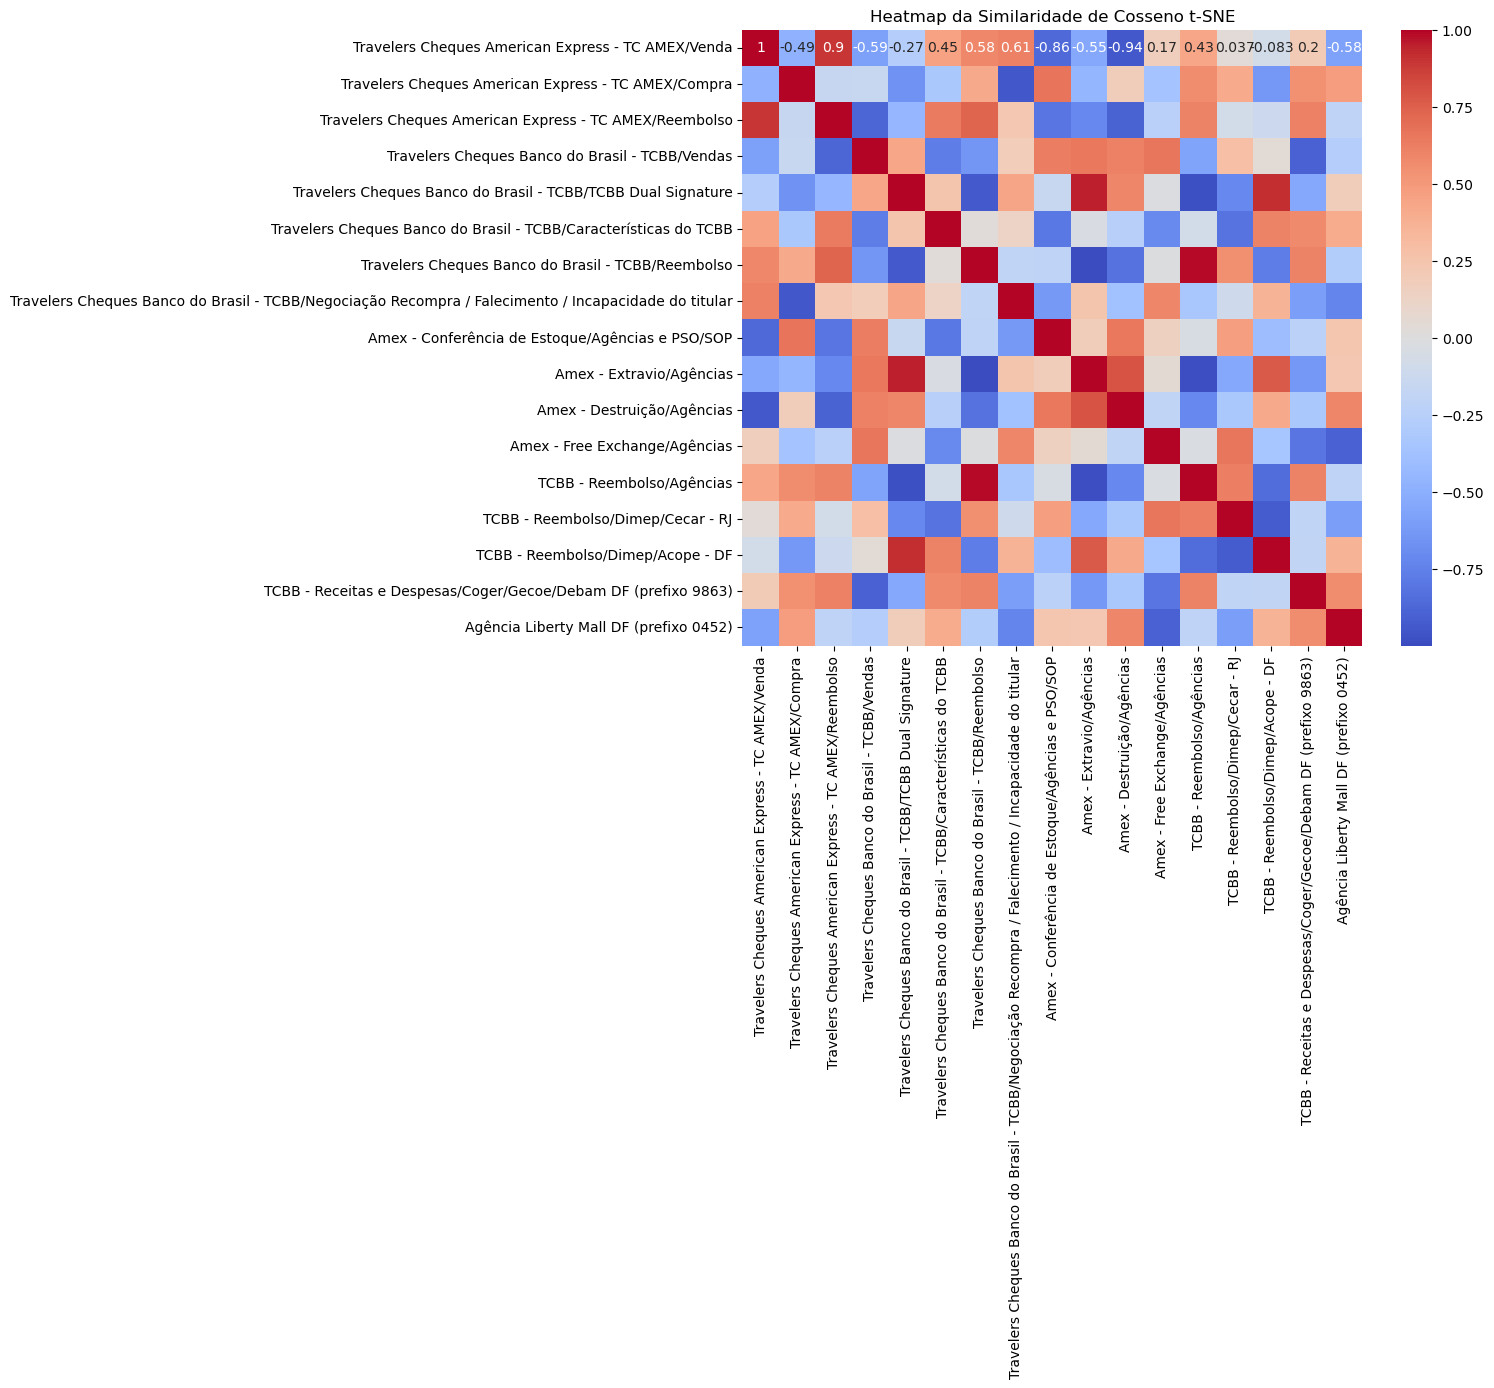

In [40]:
import seaborn as sns

# Heatmap da matriz de similaridade de cosseno para os 9 embeddings
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Heatmap da Similaridade de Cosseno t-SNE")


Text(0, 0.5, 'Componente Principal 2')

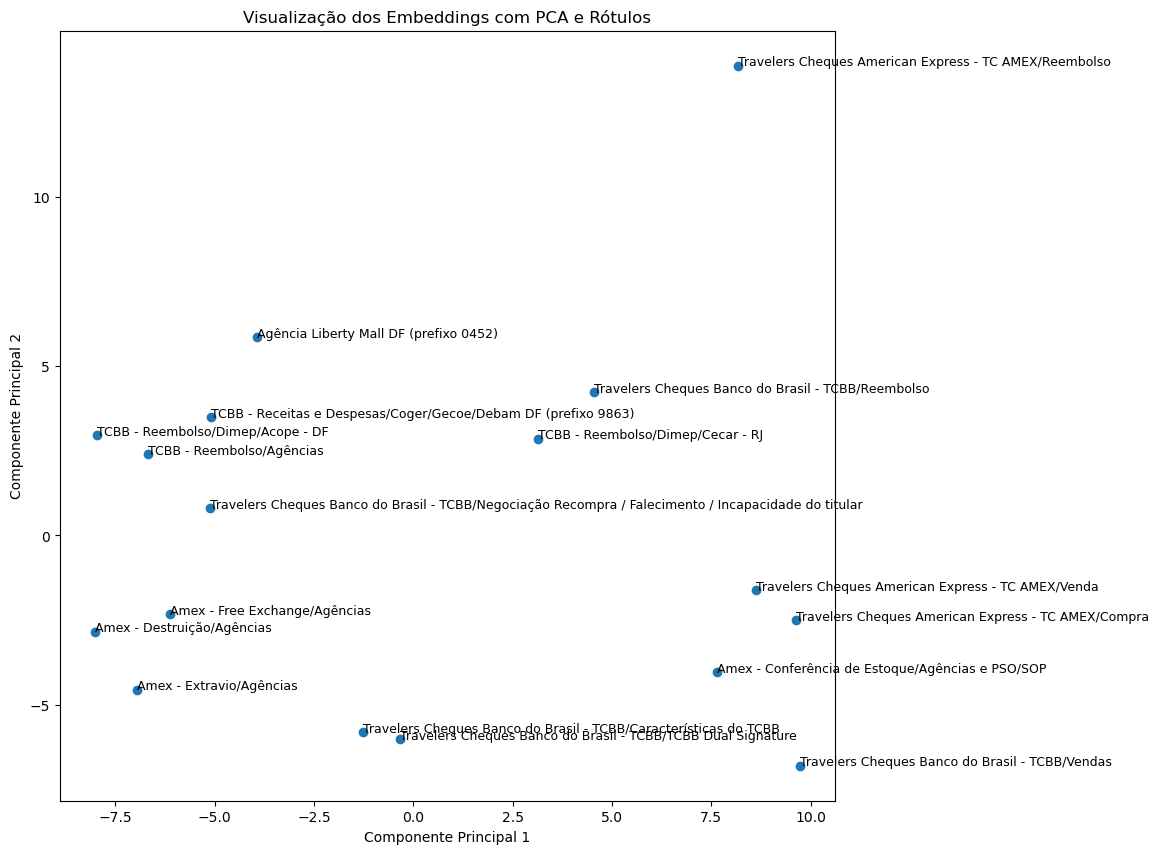

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 2D dos embeddings com rótulos
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Adicionar rótulos aos pontos
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualização dos Embeddings com PCA e Rótulos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")


(-7.914146423339844, 11.213069915771484)

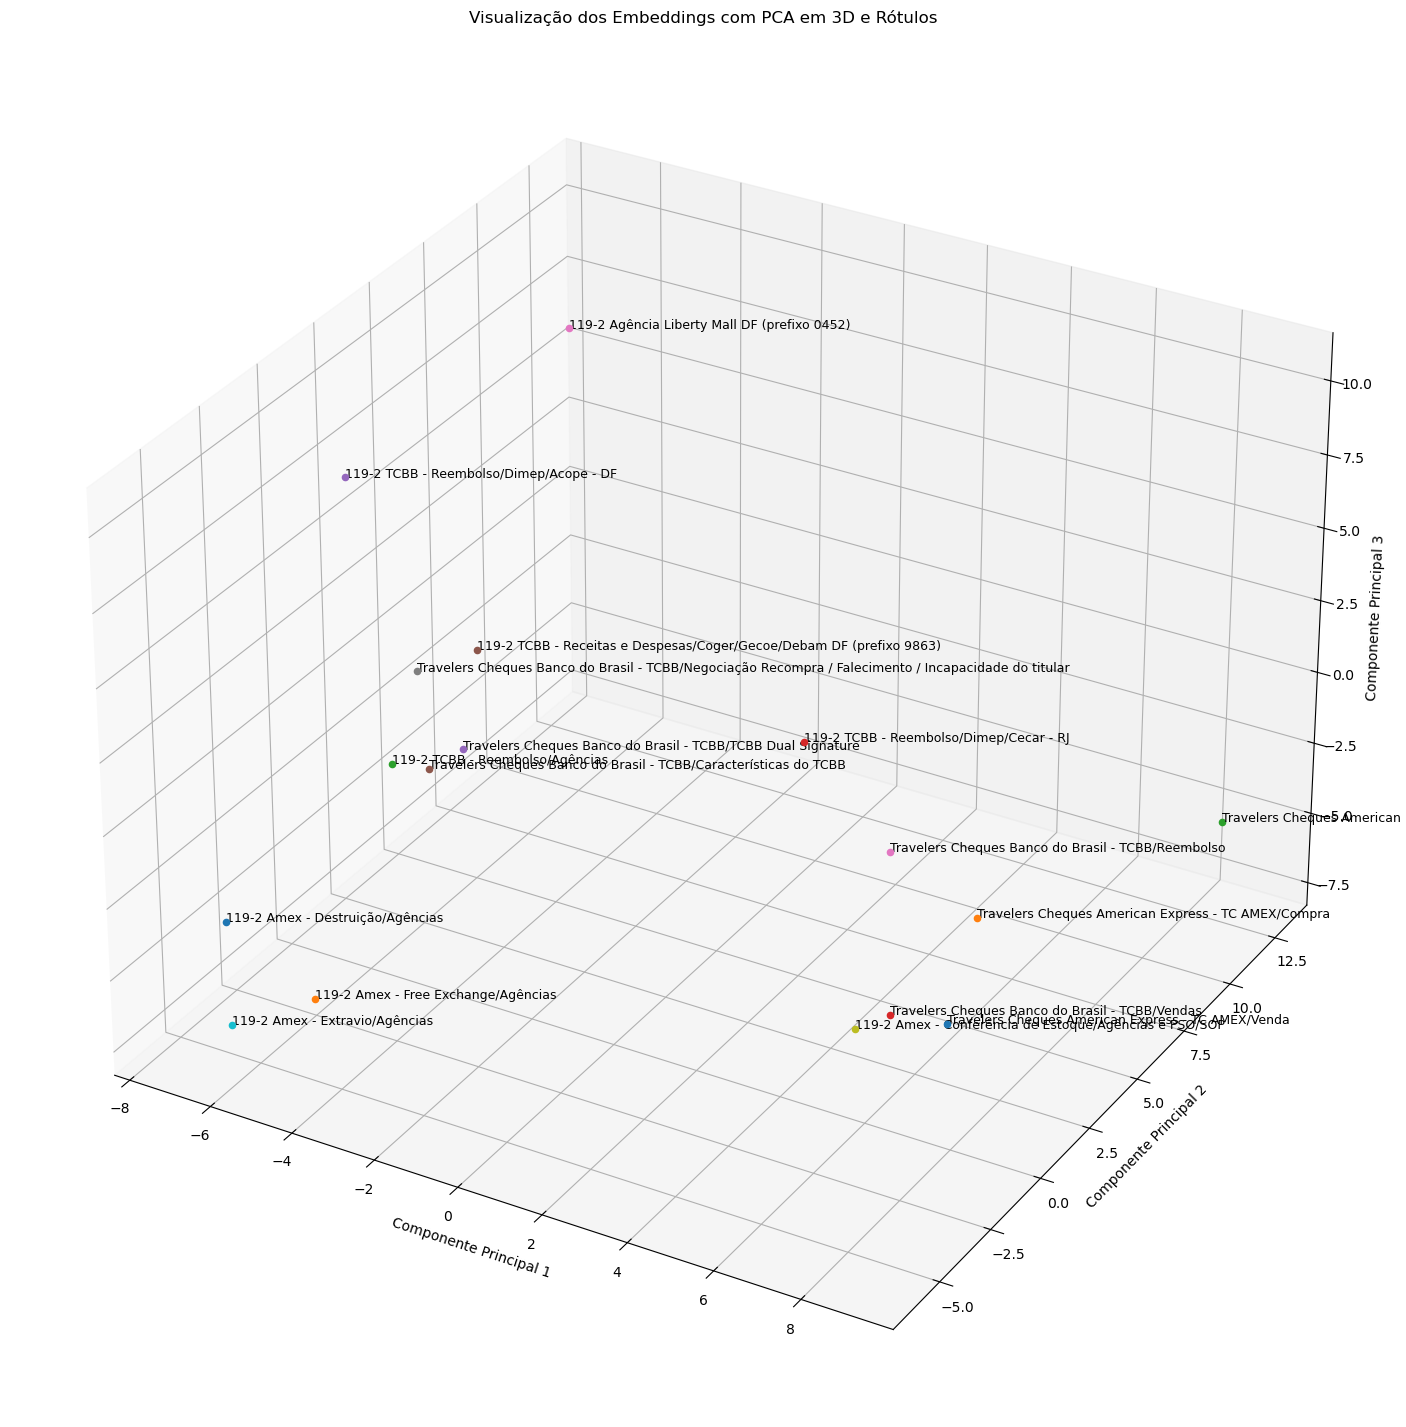

In [42]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Aplicar PCA para 3 componentes principais
pca = PCA(n_components=3)
embeddings_3d_pca = pca.fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "119-2 Amex - Conferência de Estoque/Agências e PSO/SOP",
    "119-2 Amex - Extravio/Agências",
    "119-2 Amex - Destruição/Agências",
    "119-2 Amex - Free Exchange/Agências",
    "119-2 TCBB - Reembolso/Agências",
    "119-2 TCBB - Reembolso/Dimep/Cecar - RJ",
    "119-2 TCBB - Reembolso/Dimep/Acope - DF",
    "119-2 TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "119-2 Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 3D dos embeddings após PCA com rótulos
fig = plt.figure(figsize=(18, 18))  # Aumentei o tamanho do gráfico
ax = fig.add_subplot(111, projection='3d')

for i in range(embeddings_3d_pca.shape[0]):
    ax.scatter(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], label=labels[i])
    ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], fontsize=9)

ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")

# Ajustar os limites dos eixos para garantir que todo o conteúdo seja exibido
ax.set_xlim(embeddings_3d_pca[:, 0].min(), embeddings_3d_pca[:, 0].max())
ax.set_ylim(embeddings_3d_pca[:, 1].min(), embeddings_3d_pca[:, 1].max())
ax.set_zlim(embeddings_3d_pca[:, 2].min(), embeddings_3d_pca[:, 2].max())



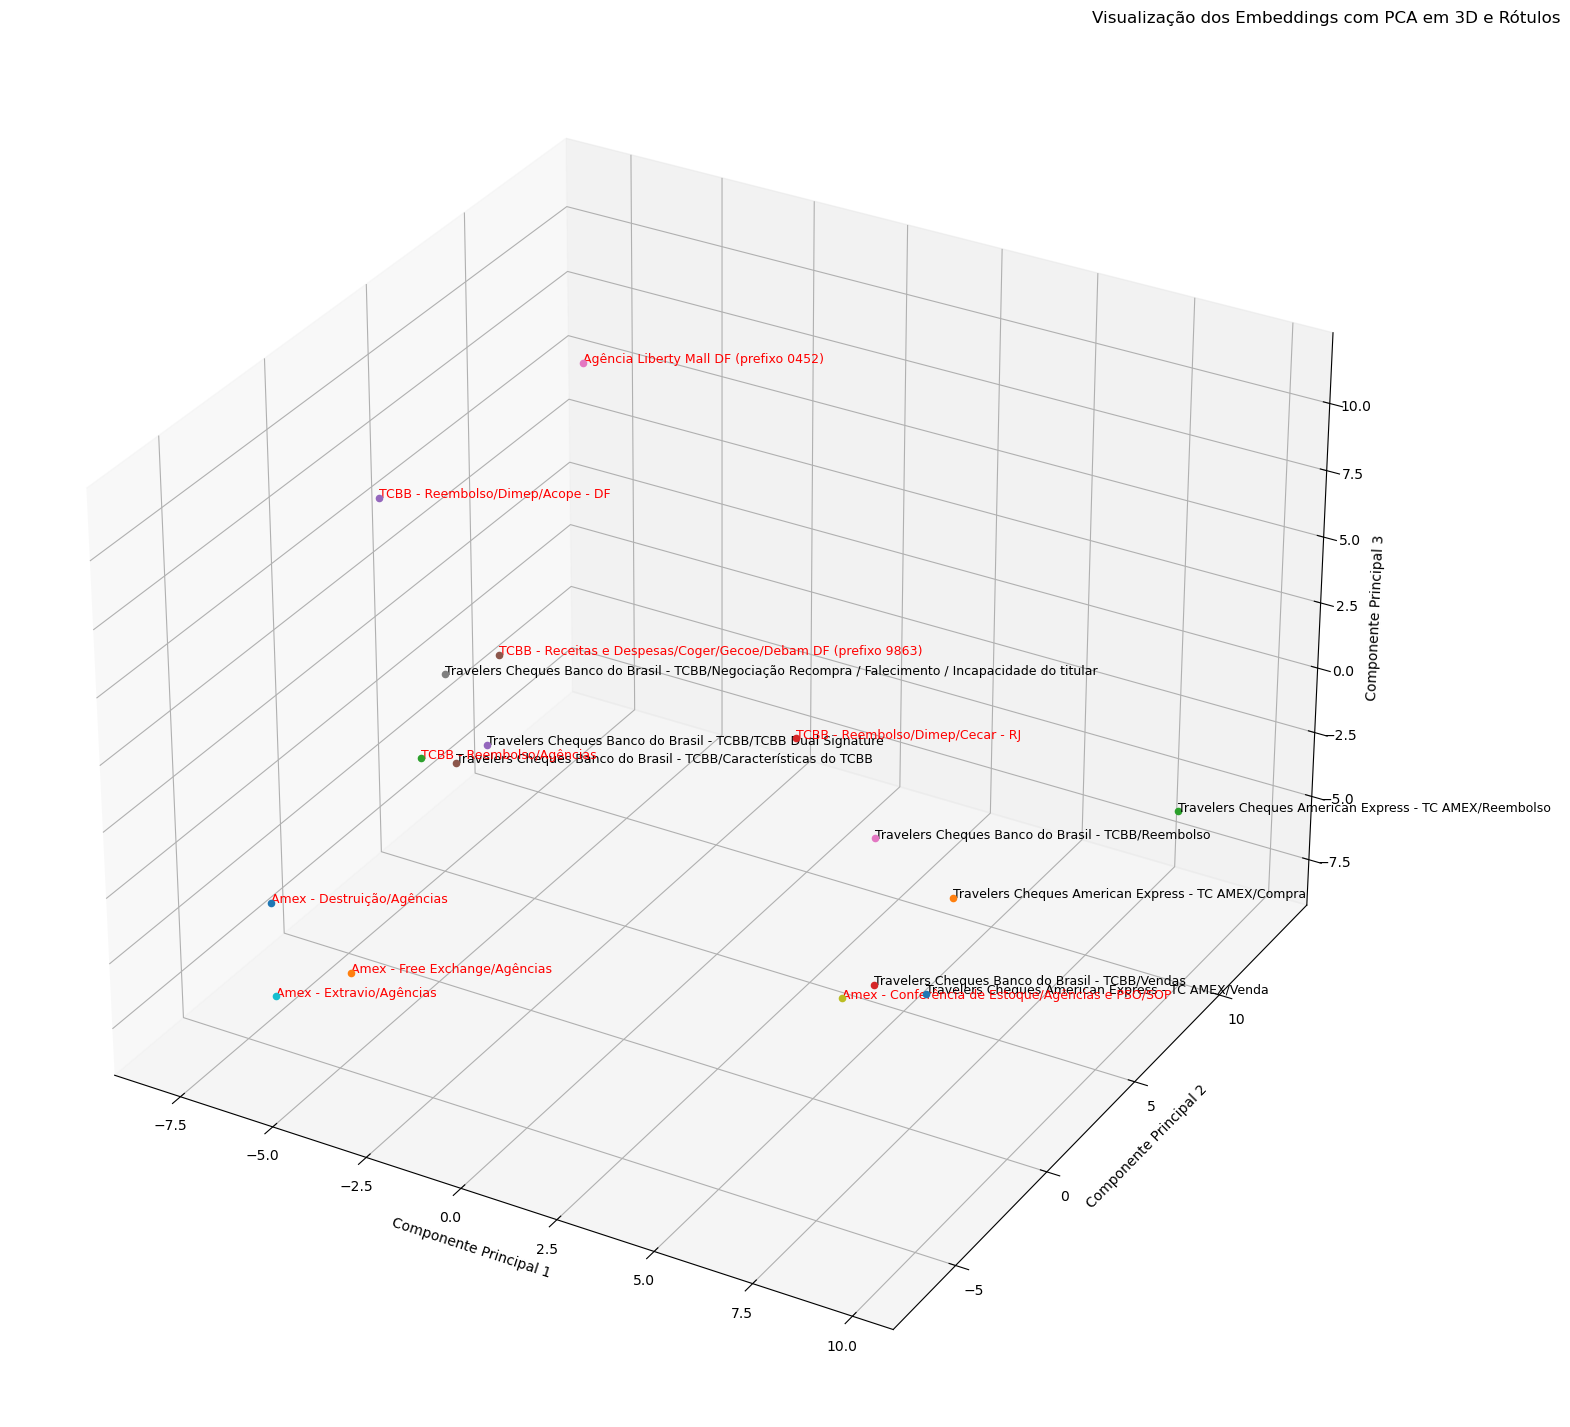

In [43]:
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Iterar sobre os embeddings
for i in range(embeddings_3d_pca.shape[0]):
    ax.scatter(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2])
    
    # Verificar se o rótulo está entre os últimos 9
    if i >= len(labels) - 9:
        ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], color='red', fontsize=9)
    else:
        ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], fontsize=9)

ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.title.set_position([0.95, 0.2])


In [44]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular a similaridade de cosseno entre os embeddings do PCA
similarity_matrix_pca = cosine_similarity(embeddings_3d_pca)

# Imprimir a matriz de similaridade
print("Matriz de Similaridade de Cosseno (PCA):")
print(similarity_matrix_pca)


Matriz de Similaridade de Cosseno (PCA):
[[ 0.99999994  0.8814638   0.40251204  0.8233416  -0.09796448 -0.1883381
   0.6315258  -0.99540967  0.9521357  -0.31920564 -0.5369116  -0.30905232
  -0.7767231   0.42574185 -0.926881   -0.9135548  -0.59416324]
 [ 0.8814638   1.          0.183175    0.93769467  0.2811171   0.15420733
   0.42215684 -0.8326454   0.9035564  -0.6209882  -0.7872862  -0.6663916
  -0.98079914  0.5699206  -0.6629441  -0.86833394 -0.21806405]
 [ 0.40251204  0.183175    0.99999994 -0.12357453 -0.8434888  -0.9191463
   0.96360266 -0.44611433  0.10382304 -0.38568997 -0.41069847 -0.20488197
  -0.03535683  0.6983662  -0.33568084  0.00358646 -0.07317927]
 [ 0.8233416   0.93769467 -0.12357453  1.          0.4840993   0.3960636
   0.1416082  -0.7724665   0.9401046  -0.3711634  -0.5601171  -0.47023347
  -0.94137096  0.2556779  -0.6812071  -0.9455614  -0.3645936 ]
 [-0.09796448  0.2811171  -0.8434888   0.4840993   0.9999999   0.9868586
  -0.7309146   0.17940506  0.18245053 -0.14539

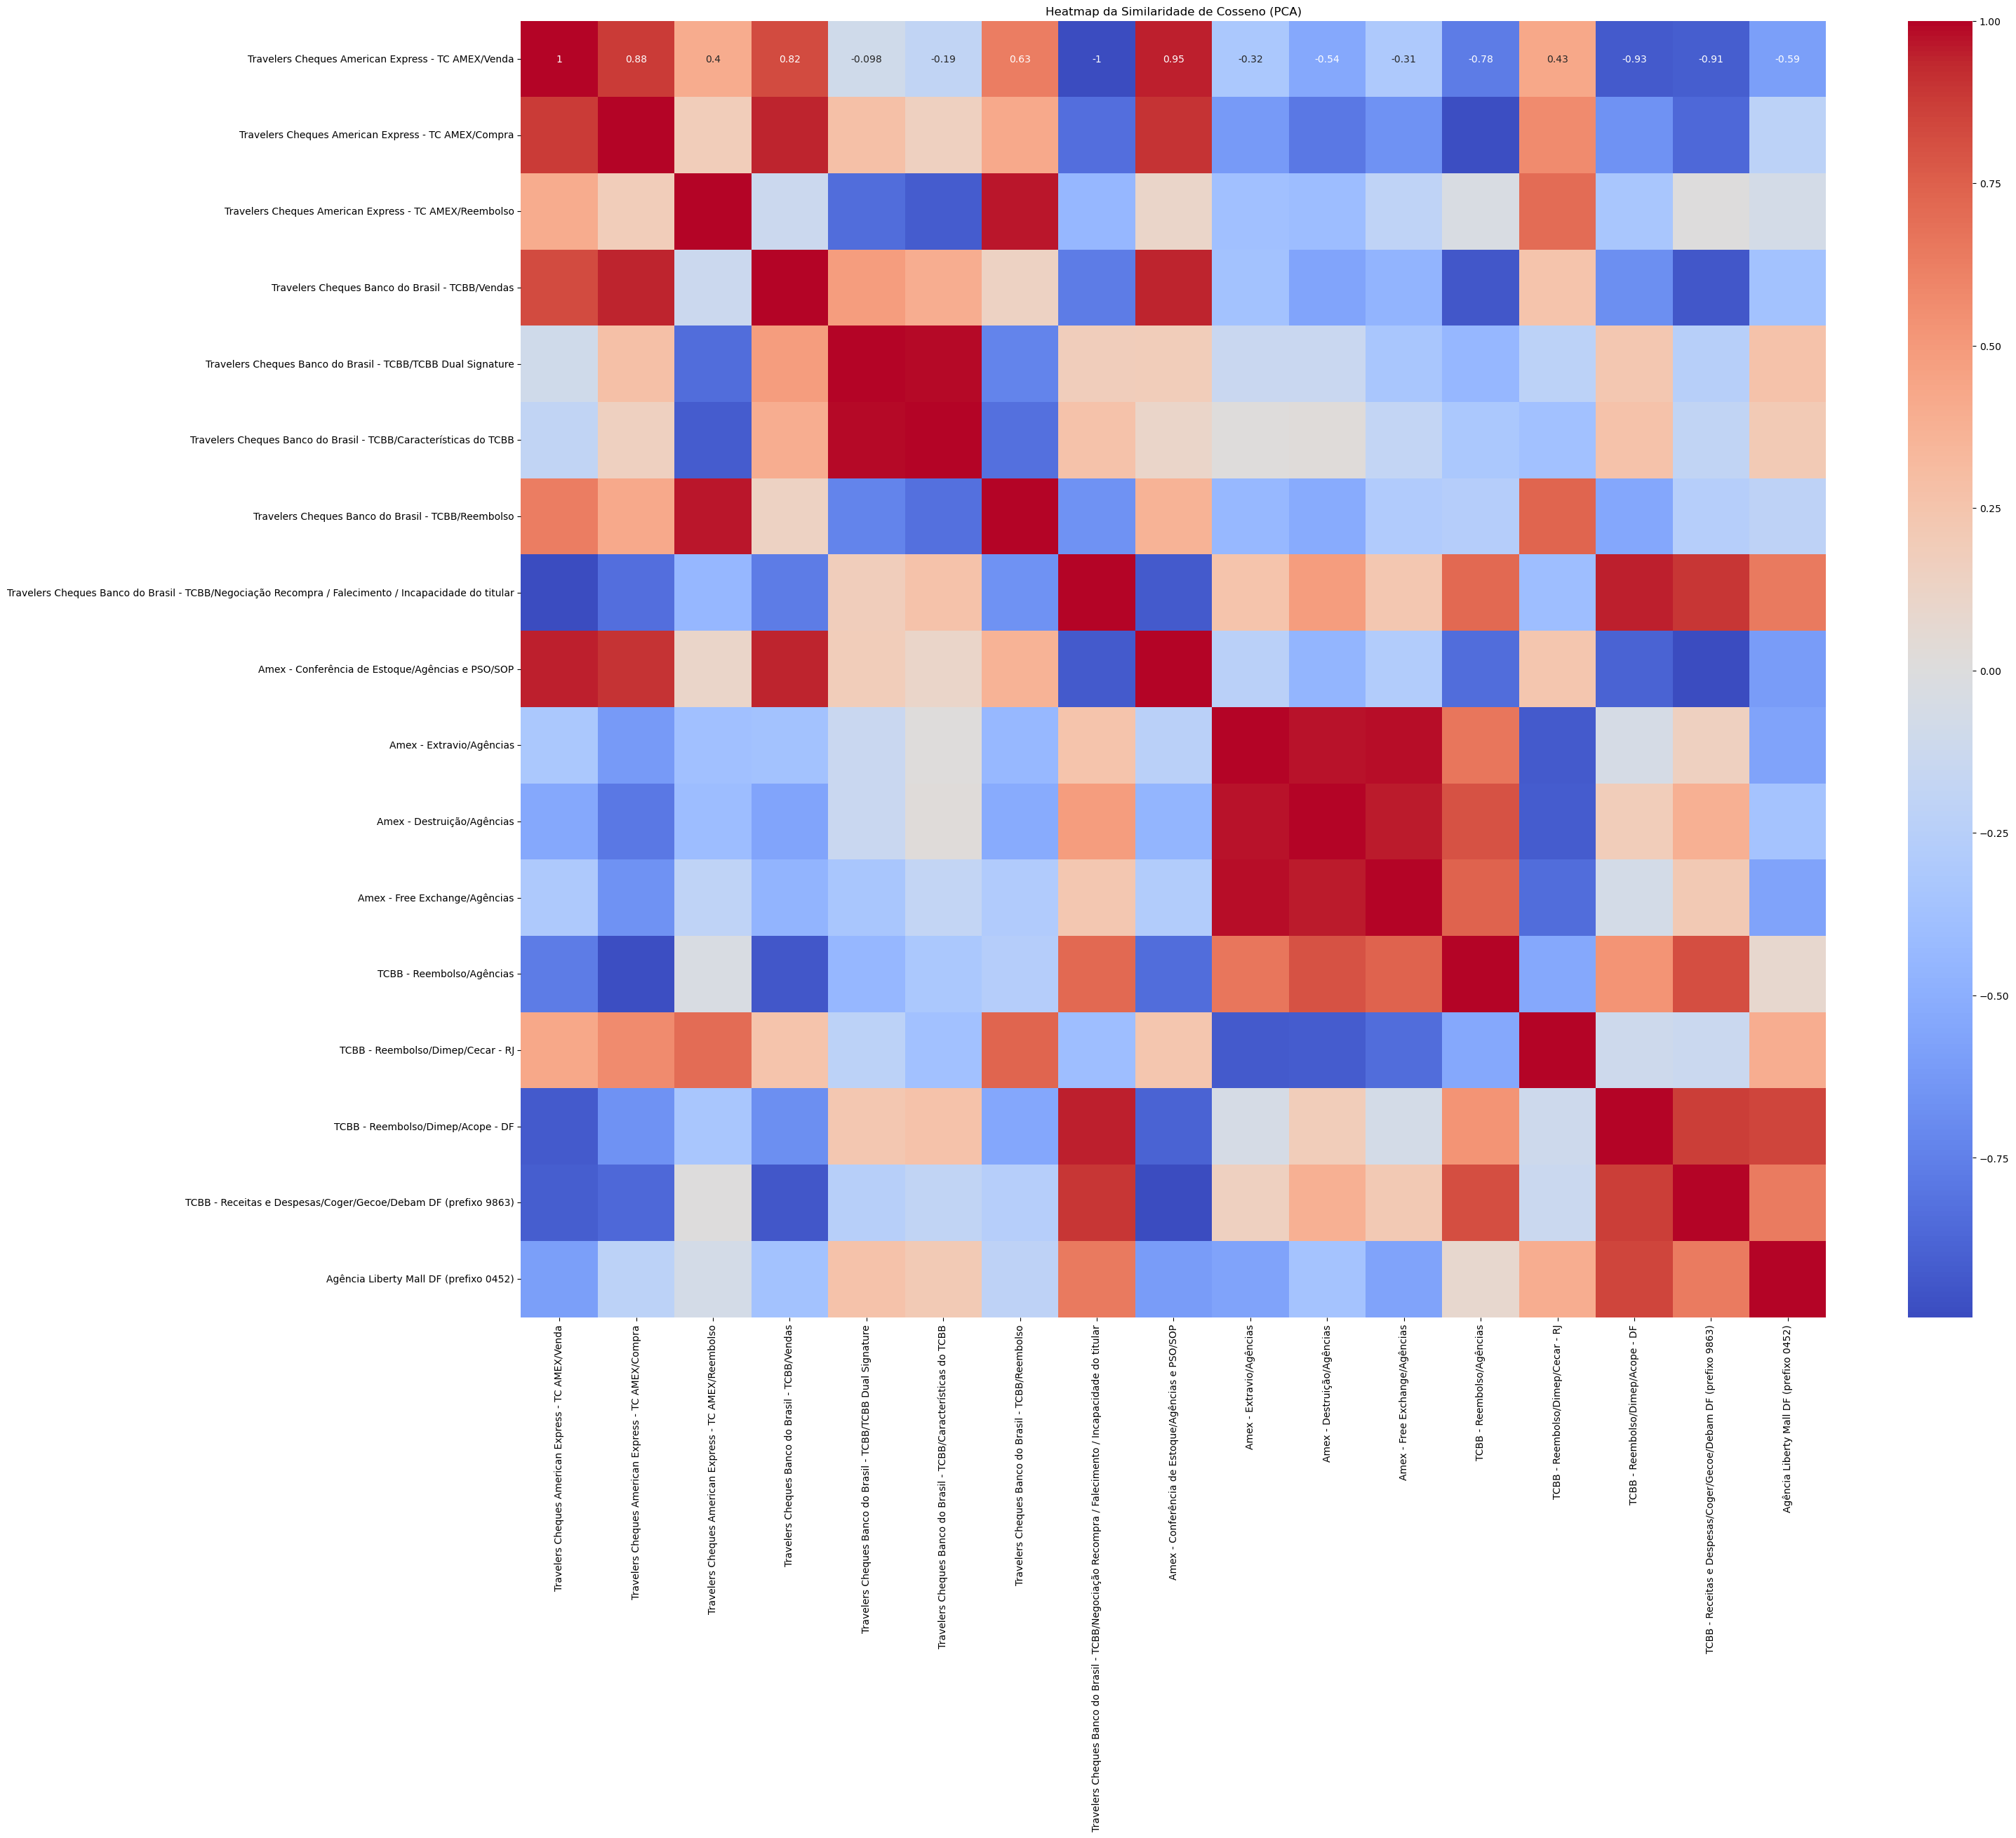

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Heatmap da matriz de similaridade de cosseno para os embeddings do PCA
plt.figure(figsize=(30, 24))
sns.heatmap(similarity_matrix_pca, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Heatmap da Similaridade de Cosseno (PCA)");
